<a href="https://colab.research.google.com/github/Vaibhav21pandit/nn_in_pytorch/blob/main/CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader

LeNet Implementation

In [ ]:
#Defining the LeNet architecture
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.pool=nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
    self.conv1=nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1),padding=(0,0))
    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1),padding=(0,0))
    self.conv3=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1),padding=(0,0))
    self.fc1=nn.Linear(in_features=120,out_features=84)
    self.fc2=nn.Linear(in_features=84,out_features=10)

  def forward(self,input_image):
    x=torch.relu(self.conv1(input_image))
    x=self.pool(x)
    x=torch.relu(self.conv2(x))
    x=self.pool(x)
    x=torch.relu(self.conv3(x))
    x=x.reshape(x.shape[0],-1)
    x=torch.relu(self.fc1(x))
    x=self.fc2(x)
    return x

model=LeNet()




In [ ]:
input=torch.rand((1,3,32,32)) #generating noise of size 32x32
print(model(input).shape) #using the generated noise for a forward pass to see if the model output is correct 

VGGNet Implementation \
Paper- https://arxiv.org/abs/1409.1556

In [ ]:
#VGG architecture

class VGGNet(nn.Module):
  def __init__(self,input_channels):
    super(VGGNet,self).__init__()
    self.in_channels=input_channels
    self.layers=[64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M"]
    self.conv_layers=self.conv_layer_creator(self.layers)
    self.fc_seq=nn.Sequential(
         nn.Linear(in_features=(512*7*7),out_features=4096),
         nn.ReLU(),
         nn.Linear(in_features=4096,out_features=4096),
         nn.ReLU(),
         nn.Linear(in_features=4096,out_features=1000)
    )

  
  def forward(self,input_image):
    x=self.conv_layers(input_image)
    print(x.shape)
    print(self.conv_layers)
    # x=nn.Flatten(x)
    x=x.reshape(x.shape[0],-1)
    x=self.fc_seq(x)
    return x

  def conv_layer_creator(self,layers):
    conv_layers=[]
    in_channels=self.in_channels
    for i in layers:
      if i=="M":
        conv_layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
      else:
        #note the padding factor of 1
        conv_layers.append(nn.Conv2d(in_channels=in_channels,out_channels=i,kernel_size=(3,3),stride=(1,1),padding=(1,1)))
        # A BatchNorm can be added but not implemented in the original paper
        conv_layers.append(nn.ReLU())
        in_channels=i
    return nn.Sequential(*conv_layers)

model=VGGNet(3)




In [ ]:
input_image=torch.rand((1,3,224,224))
print(model(input_image).shape)

**Debugging** \
Forgot to add padding in the Conv2d module and was getting error so the following cell shows how to debug a neural net when shapes dont match

In [ ]:
#This is how to debug a model,no need for a class for a forward pass.just input in the sequential layers. 
layers=[64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512]
def conv_layer_creator(layers):
  conv_layers=[]
  in_channels=3
  for i in layers:
    if i=="M":
      conv_layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
    else:
      conv_layers.append(nn.Conv2d(in_channels=in_channels,out_channels=i,kernel_size=(3,3),stride=(1,1)))
      # A BatchNorm can be added but not implemented in the original paper
      conv_layers.append(nn.ReLU())
      in_channels=i
  return nn.Sequential(*conv_layers)
conv_layers=conv_layer_creator(layers)
print(conv_layers(input_image).shape)

Implementing AlexNet \
Paper-https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [ ]:
# a conv block in AlexNet Looks Like this:
# Conv2d --> Relu -->  LocalResponseNorm -->  Maxpool2d
class AlexNet(nn.Module):
  def __init__(self,in_channels):
    super(AlexNet,self).__init__()
    self.in_channels=in_channels
    #LocalResponseNorm has no  effect on feature_size,just like BatchNorm
    self.responseNorm=nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2) 
    self.pool=nn.MaxPool2d((3,3),stride=(2,2))
    self.flatten=nn.Flatten()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=96,kernel_size=(11,11),stride=(4,4))
    self.conv2=nn.Conv2d(in_channels=96,out_channels=256,kernel_size=(5,5),padding=(2,2))
    self.conv3=nn.Conv2d(in_channels=256,out_channels=384,kernel_size=(3,3),padding=(1,1))
    self.conv4=nn.Conv2d(in_channels=384,out_channels=384,kernel_size=(3,3),padding=(1,1))
    self.conv5=nn.Conv2d(in_channels=384,out_channels=256,kernel_size=(3,3),padding=(1,1))
    self.fc1=nn.Linear((256*6*6),4096)
    self.fc2=nn.Linear(4096,4096)
    self.fc3=nn.Linear(4096,1000)


  def forward(self,input_image):
    x=self.pool(self.responseNorm(torch.relu(self.conv1(input_image))))
    x=self.pool(self.responseNorm(torch.relu(self.conv2(x))))
    x=torch.relu(self.conv3(x))
    x=torch.relu(self.conv4(x))
    x=torch.relu(self.conv5(x))
    x=self.pool(x)
    x=x.reshape(x.shape[0],-)
    print(x.shape)
    x=torch.relu(self.fc1(x))
    x=torch.relu(self.fc2(x))
    x=self.fc3(x)
    return x
net=AlexNet(in_channels=3)

In [ ]:
input_image=torch.rand((1,3,224,224))
print(net(input_image).shape)

In [ ]:
# #Experimentation
# input_image=torch.rand((1,3,224,224))
# net=nn.Sequential(
#     nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=1)
#     ,nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
#     ,nn.Flatten())
# print(net(input_image).shape)

Inception v1 Implementation \
Paper - https://arxiv.org/pdf/1409.4842.pdf

[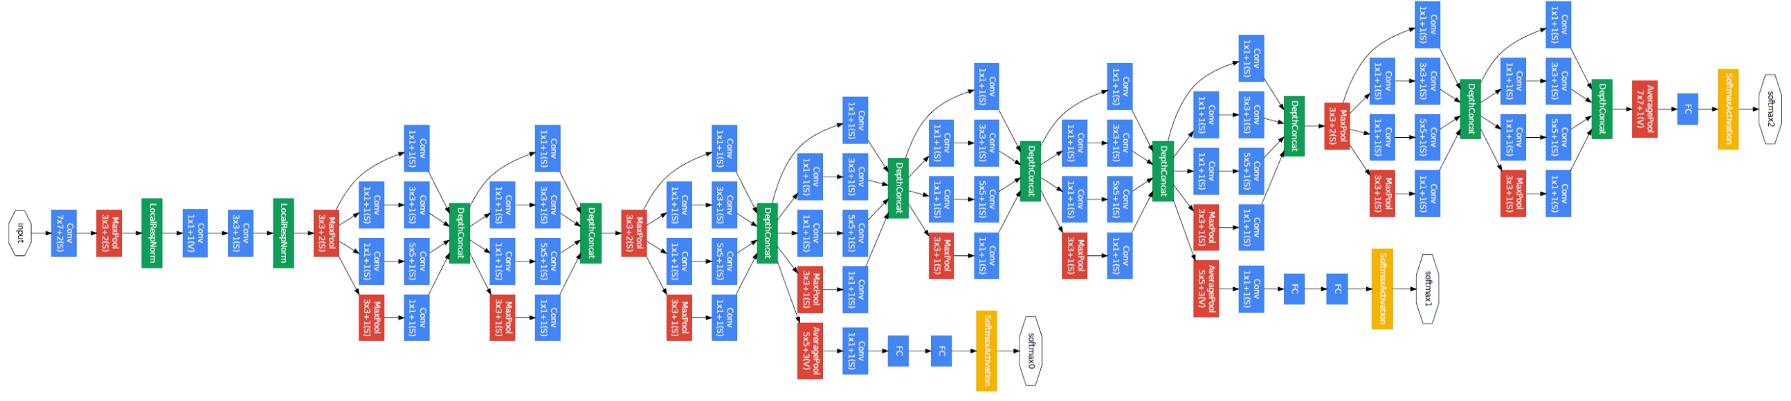](https://miro.medium.com/max/700/1*uW81y16b-ptBDV8SIT1beQ.png)

In the above architecture only the last output has beenn implemented, not the intermediate outputs.Also BatchNorm has been used instead of LocalResponseNorm

In [ ]:
class Conv_block():
  def __init__(self,in_channels,out_channels,kernel_size,stride,padding):
    super(Conv_block,self).__init__()
    self.conv=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size
                        ,stride=stride,padding=padding)
    self.relu=nn.ReLU()
    self.batch_norm=nn.BatchNorm2d(num_features=64)
  
  def forward(self,input_image):
    return self.relu(self.batch_norm(self.conv(input_image)))

class Inception_block(nn.Module):
  def __init__(self,in_channels, out_1x1, in_3x3, out_3x3, in_5x5, out_5x5, out_1x1pool):
    super(Inception_block,self).__init__()
    self.branch1=Conv_block(in_channels=in_channels,out_channels=out_1x1,kernel_size=(1,1),stride=(1,1),padding=(1,1))
    self.branch2=nn.Sequential(
        Conv_block(in_channels=in_channels,out_channels=in_3x3,kernel_size=(1,1),padding=(1,1),stride=(1,1)),
        Conv_block(in_channels=in_3x3,out_channels=out_3x3,kernel_size=1,padding=(1,1),stride=(1,1))
    )
    self.branch3=nn.Sequential(
        Conv_block(in_channels=in_channels,out_channels=in_5x5,kernel_size=(1,1),padding=(1,1),stride=(1,1)),
        Conv_block(in_channels=in_5x5,out_channels=out_5x5,kernel_size=(5,5),stride=(1,1),padding=(2,2))
    )
    self.branch4=nn.Sequential(
        nn.MaxPool2d(kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        Conv_block(in_channels=in_channels,out_channels=out_1x1pool,kernel=(1,1),stride=(1,1),padding=(1,1))
    )

  def forward(self,input_image):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class InceptionNet(nn.Module):
  def __init__(self):
    super(InceptionNet,self).__init__()
    self.conv1=Conv_block(3,64,7,2,3)
    self.pool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2=Conv_block(64,192,3,1,1)
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, 1000)
  
  def forward(self,input_image):
    x=self.pool(self.conv1(input_image))
    x=self.pool(self.conv2(x))
    x=self.inception3a(x)
    x=self.inception3b(x)
    x=self.pool(x)
    x=self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)
    return x
net=InceptionNet()

In [ ]:
class VGG(nn.Module):
    def __init__(self,num_classes=1000):
        super(VGG, self).__init__()

        # Write in_channels, etc, all explicit in self.conv1, rest will write to
        # make everything as compact as possible, kernel_size=3 instead of (3,3)
        self.conv1 = conv_block(
            in_channels=3,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, 1000)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

net=VGG()

In [ ]:
input_noise=torch.randn((1,3,64,64))
print(net(input_noise).shape)